In [ ]:
!pip install --no-deps overcomplete

In [51]:
import torch
from torch import nn

import overcomplete
from overcomplete import *
from overcomplete.sae.base import SAE

In [53]:
import torch
from torch import nn

from overcomplete.sae.base import SAE

class Sparsemax(nn.Module):
    def __init__(self, dim=-1):
        super(Sparsemax, self).__init__()
        self.dim = dim

    def forward(self, input):

        input_shifted = input - input.max(dim=self.dim, keepdim=True)[0]

        zs = torch.sort(input_shifted, dim=self.dim, descending=True)[0]
        zs_cumsum = zs.cumsum(dim=self.dim) - 1  # Subtract 1 as per the Sparsemax formula

        range_dim = zs.size(self.dim)
        rhos = torch.arange(1, range_dim + 1, device=input.device, dtype=input.dtype)
        rhos_shape = [1] * input.dim()
        rhos_shape[self.dim] = -1
        rhos = rhos.view(rhos_shape)

        support = zs > zs_cumsum / rhos
        k = support.sum(dim=self.dim, keepdim=True)

        tau_sum = zs_cumsum.gather(self.dim, k - 1)
        tau = tau_sum / k.type(input.dtype)
        tau = tau.expand_as(input)

        output = torch.clamp(input_shifted - tau, min=0)

        return output

def identity_encoder(x):
            return x, x
identity_module = nn.Module()
identity_module.forward = identity_encoder

class Spade(SAE):
    def __init__(self, input_shape, nb_concepts, top_k=None, threshold_momentum=0.9,
                 encoder_module=None, dictionary_params=None, device='cpu', nb_archetypes=None):

        super().__init__(input_shape, nb_concepts, identity_module,
                         dictionary_params, device)

        if nb_archetypes is None:
            nb_archetypes = nb_concepts

        self.nb_archetypes = nb_archetypes

        alphas = torch.randn(nb_archetypes, input_shape, device=device)
        self.alphas = torch.nn.Parameter(alphas, requires_grad=True)

        temperature = torch.tensor(0.0, device=device)
        self.temperature = torch.nn.Parameter(temperature, requires_grad=True)

        self.sparsemax = Sparsemax(dim=-1)

    def encode(self, x):
        pre_codes, _ = self.encoder(x)

        # distance as matrix multiplication
        a = pre_codes
        b = self.alphas

        a2 = (a ** 2).sum(dim=1, keepdim=True)
        b2 = (b ** 2).sum(dim=1, keepdim=True)
        ab = a @ b.T
        dist = a2 + b2.T - 2 * ab
        dist = dist

        # old distance
        #dist = torch.mean((pre_codes[:, None, :] - self.alphas[None, :, :]).square(), 2)

        codes = self.sparsemax(- torch.exp(self.temperature) * dist)

        return dist, codes


In [54]:
data = torch.load('vision_data_experiment.pth')
data.keys()

/tmp/ipykernel_2450567/848121314.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('vision_data_experiment.pth')


dict_keys(['cls_tokens', 'z_spade', 'z_jump', 'z_topk', 'preds', 'spade_sae', 'alphas', 'jump_sae', 'topk_sae'])

In [55]:
data['cls_tokens'].shape, data['preds'].shape, data['z_spade'].shape, data['z_jump'].shape, data['z_topk'].shape

(torch.Size([11511, 768]),
 torch.Size([11511]),
 torch.Size([11511, 200]),
 torch.Size([11511, 200]),
 torch.Size([11511, 200]))

In [56]:
activations = data['cls_tokens']
classes = data['preds']

sae_spade, sae_jump, sae_topk = data['spade_sae'], data['jump_sae'], data['topk_sae']
_, codes = sae_spade.encode(activations)
codes.shape

torch.Size([11511, 200])

In [57]:
class_names = {
    574: "Golf ball",
    571: "Gas pump",
    569: "Garbage truck",
    0:   "Tench",
    701: "Parachute",
    217: "English Springer",
    566: "French horn",
    491: "Chainsaw",
    497: "Church",
    482: "Casette player"
}
imagenet_id_to_idx = {int(c): i for i, c in enumerate(class_names.keys())}
idx_to_imagenet_id = {v: k for k,v in imagenet_id_to_idx.items()}
id_to_classname = {v: class_names[k] for k,v in imagenet_id_to_idx.items()}

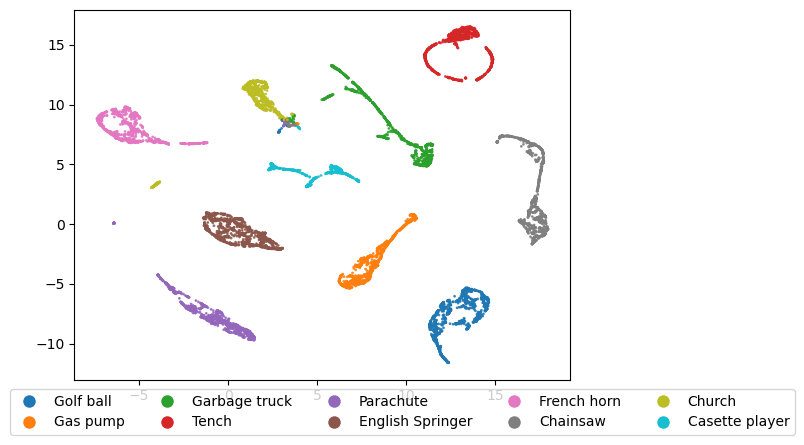

In [58]:
import umap
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

reducer = umap.UMAP(n_neighbors=20, min_dist=0.01, n_components=2, metric='euclidean')
codes_umap = reducer.fit_transform(codes.detach().cpu().numpy())

plt.scatter(codes_umap[:, 0], codes_umap[:, 1], s=1, c=[imagenet_id_to_idx[int(c)] for c in classes], cmap='tab10', alpha=0.8)
legend_elements = [Line2D([0], [0], marker='o', color='w', label=name,
                          markerfacecolor=plt.cm.tab10(i), markersize=10) for i, name in id_to_classname.items()]
plt.legend(handles=legend_elements, loc=(-0.13, -0.15), ncol=5)
plt.show()

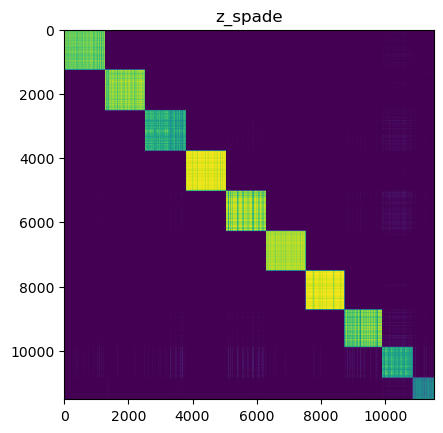

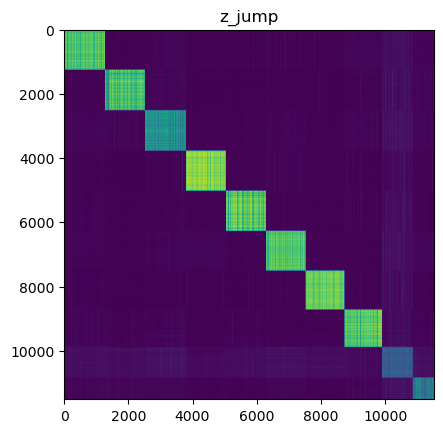

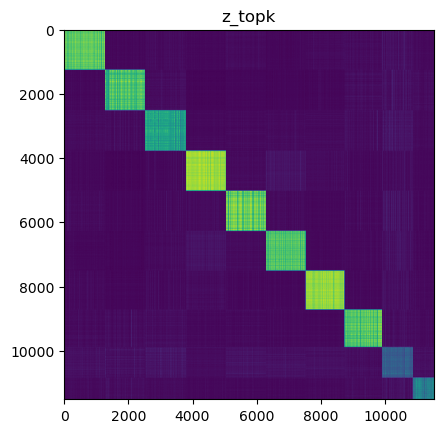

In [60]:
for kcodes in ['z_spade', 'z_jump', 'z_topk']:

  codes = data[kcodes]
  codes = codes / codes.norm(dim=1, keepdim=True)

  blocks = []
  for i in range(10):
      tokens = codes[classes == idx_to_imagenet_id[i]]
      blocks.append(tokens)

  blocks = torch.cat(blocks, dim=0)
  ZZt = blocks @ blocks.T

  plt.imshow(ZZt.detach().cpu().numpy(), cmap='viridis')
  plt.title(kcodes)
  plt.show()

In [ ]:
# landmarks/archetypes
sae_spade = data['spade_sae']
sae_spade.alphas.shape, sae_spade.temperature.exp()

(torch.Size([200, 768]),
 Parameter containing:
 tensor(-6.3286, requires_grad=True),
 tensor(0.0018, grad_fn=<ExpBackward0>))